In [55]:
import pandas as pd

In [56]:
df_sleep = pd.read_csv("Sleep.csv")
df_social = pd.read_csv("Social.csv")


print(df_sleep.head())
print(df_social.head())

  user_id   resp_time               datetime_utc  sleep_hours  sleep_quality  \
0     u00  1364114365  2013-03-24 08:39:25+00:00          NaN            NaN   
1     u00  1364114453  2013-03-24 08:40:53+00:00          NaN            NaN   
2     u00  1364114760  2013-03-24 08:46:00+00:00          NaN            NaN   
3     u00  1364114761  2013-03-24 08:46:01+00:00          NaN            NaN   
4     u00  1364114765  2013-03-24 08:46:05+00:00          NaN            NaN   

   sleepiness location  
0         NaN      NaN  
1         NaN      NaN  
2         NaN      NaN  
3         NaN      NaN  
4         NaN      NaN  
  user_id   resp_time               datetime_utc  number location
0     u00  1364114390  2013-03-24 08:39:50+00:00     NaN      NaN
1     u00  1364114393  2013-03-24 08:39:53+00:00     NaN      NaN
2     u00  1364114455  2013-03-24 08:40:55+00:00     NaN      NaN
3     u00  1364163095  2013-03-24 22:11:35+00:00     NaN      NaN
4     u00  1364177775  2013-03-25 02:16

### Grouping Dates

In [59]:
def fill_forward_dates(df, date_col, forward=True):
    # Parse datetimes safely
    df[date_col] = pd.to_datetime(df[date_col], utc=True)

    # Extract just the date part
    df["date"] = df[date_col].dt.date

    # Daily aggregation — adjust method if needed
    daily_df = df.groupby(["user_id", "date"]).mean(numeric_only=True)

    # Build full date range
    all_dates = pd.date_range(start=df["date"].min(), end=df["date"].max())

    # Reindex with full dates
    daily_df = daily_df.reindex(all_dates)

    # Fill missing with ffill or bfill
    # Fill based on direction
    if forward:
        daily_df = daily_df.ffill()
    elif not forward:
        daily_df = daily_df.bfill()
    else:
        raise ValueError("Invalid value for 'forward'. Must be True or False.")

    # Reset and rename
    daily_df = daily_df.reset_index().rename(columns={"index": "date"})

    return daily_df


sleep_forward = fill_forward_dates(df_sleep, "datetime_utc", True)

ValueError: cannot include dtype 'M' in a buffer

In [58]:
print(sleep_forward.head())

        date     resp_time  sleep_hours  sleep_quality  sleepiness
0 2013-03-24  1.364121e+09          NaN            NaN         NaN
1 2013-03-25  1.364238e+09     8.000000       1.000000    1.000000
2 2013-03-26  1.364328e+09     7.500000       1.500000    1.000000
3 2013-03-27  1.364398e+09     7.105263       1.684211    1.184211
4 2013-03-28  1.364489e+09     7.096774       2.064516    1.387097


In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Fill missing dates for each user using the existing fill_forward_dates function
for user in sleep_forward["user_id"].unique():
    user_df = sleep_forward[sleep_forward["user_id"] == user].copy()

    # Fill missing dates (forward fill or backward fill)
    filled_user_df = fill_forward_dates(user_df, date_col="datetime_utc", forward=True)

    # Plot each user's sleep pattern
    plt.figure(figsize=(10, 4))
    plt.plot(
        filled_user_df["date"], filled_user_df["sleep_hours"], marker="o", linestyle="-"
    )

    plt.title(f"Sleep Pattern for {user}")
    plt.xlabel("Date")
    plt.ylabel("Sleep Hours")
    plt.xticks(rotation=45)
    plt.ylim(0, sleep_forward["sleep_hours"].max() + 1)
    plt.tight_layout()
    plt.show()

KeyError: 'user_id'

### Ungrouping Dates afterwards

In [ ]:
def fill_missing_dates_with_aggregates(df, datetime_col, forward=True):
    # Step 1: Ensure datetime column
    df[datetime_col] = pd.to_datetime(df[datetime_col], utc=True)
    df["date"] = df[datetime_col].dt.date

    # Step 2: Create daily aggregate table
    daily_agg = df.groupby("date").mean(numeric_only=True)

    # Step 3: Reindex to include missing dates
    all_dates = pd.date_range(start=df["date"].min(), end=df["date"].max()).date
    daily_agg = daily_agg.reindex(all_dates)

    # Step 4: Fill missing values
    if forward:
        daily_filled = daily_agg.ffill()
    elif not forward:
        daily_filled = daily_agg.bfill()
    else:
        raise ValueError("Unsupported method. Use 'True' or 'False'.")

    # Step 5: Identify missing dates
    existing_dates = set(df["date"])
    missing_dates = [d for d in all_dates if d not in existing_dates]

    # Step 6: Create placeholder rows using filled aggregates
    placeholder_rows = daily_filled.loc[missing_dates].copy()
    placeholder_rows["date"] = missing_dates
    placeholder_rows[datetime_col] = [
        pd.Timestamp(d).replace(tzinfo=pd.Timestamp(df[datetime_col].iloc[0]).tzinfo)
        for d in missing_dates
    ]

    # Step 7: Combine and sort
    df_with_placeholders = pd.concat(
        [df, placeholder_rows.reset_index(drop=True)], ignore_index=True
    )
    df_with_placeholders = df_with_placeholders.sort_values(
        by=datetime_col
    ).reset_index(drop=True)

    return df_with_placeholders

In [ ]:
sleep_forward = fill_missing_dates_with_aggregates(df_sleep, "datetime_utc", True)
social_forward = fill_missing_dates_with_aggregates(df_social, "datetime_utc", True)

sleep_back = fill_missing_dates_with_aggregates(df_sleep, "datetime_utc", False)
social_back = fill_missing_dates_with_aggregates(df_social, "datetime_utc", False)

print(sleep_forward.tail(5))

     user_id     resp_time              datetime_utc  sleep_hours  \
1639     u57  1.370372e+09 2013-06-04 18:56:03+00:00          6.0   
1640     u59  1.370388e+09 2013-06-04 23:18:02+00:00         13.0   
1641     u56  1.370458e+09 2013-06-05 18:54:11+00:00          7.0   
1642     u59  1.370477e+09 2013-06-06 00:06:14+00:00         15.0   
1643     u59  1.370649e+09 2013-06-07 23:46:41+00:00          5.0   

      sleep_quality  sleepiness                               location  \
1639            2.0         1.0               43.70713643,-72.28841499   
1640            1.0         1.0  29.902872280217707,-90.02744721248746   
1641            3.0         1.0                                Unknown   
1642            1.0         1.0  29.902795627713203,-90.02727152779698   
1643            2.0         3.0  29.899868331849575,-90.02978006377816   

            date  
1639  2013-06-04  
1640  2013-06-04  
1641  2013-06-05  
1642  2013-06-06  
1643  2013-06-07  


/var/folders/f4/vybgzbbx1sg165hn_kn98j0m0000gn/T/ipykernel_15771/1490404024.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_with_placeholders = pd.concat(
/var/folders/f4/vybgzbbx1sg165hn_kn98j0m0000gn/T/ipykernel_15771/1490404024.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_with_placeholders = pd.concat(
/var/folders/f4/vybgzbbx1sg165hn_kn98j0m0000gn/T/ipykernel_15771/1490404024.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

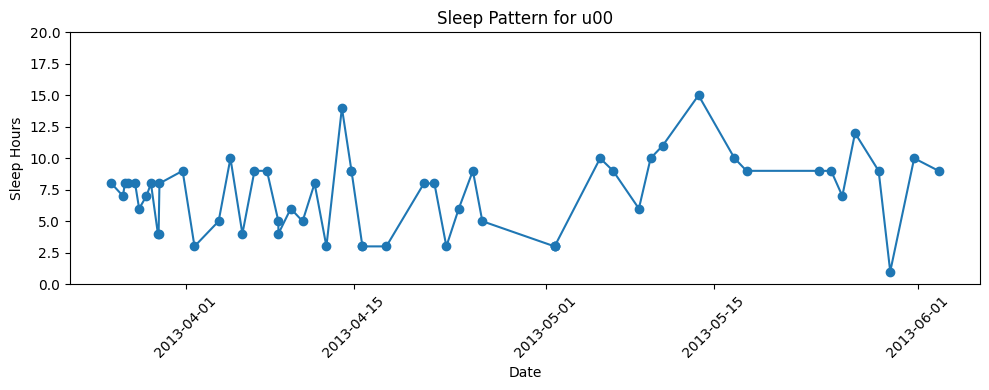

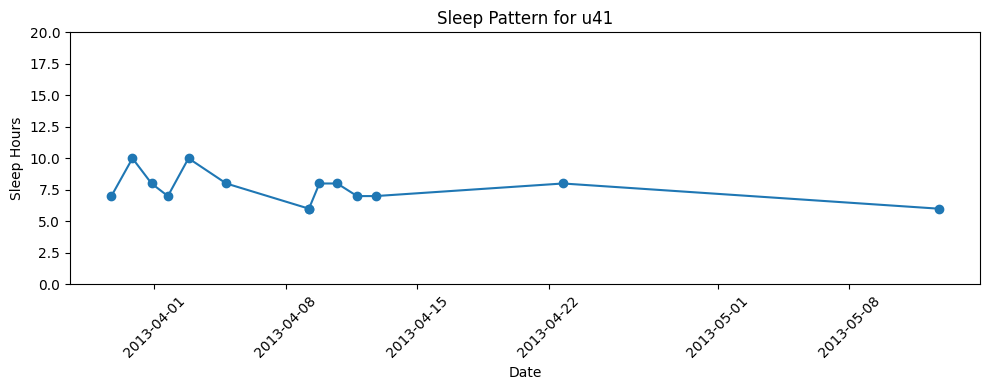

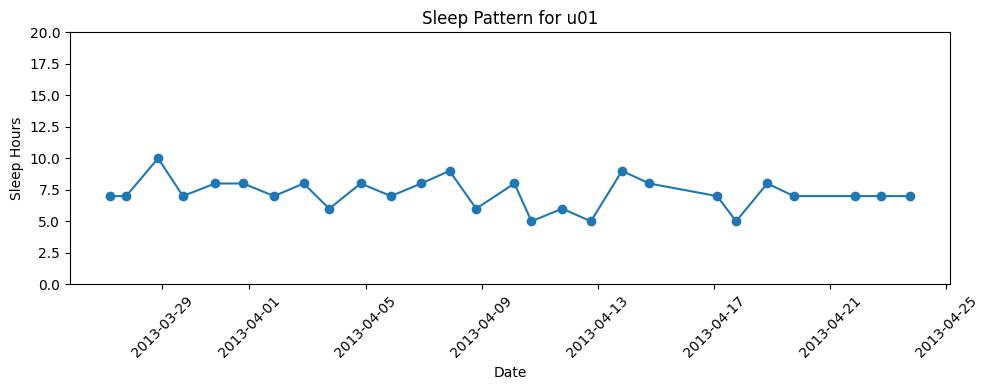

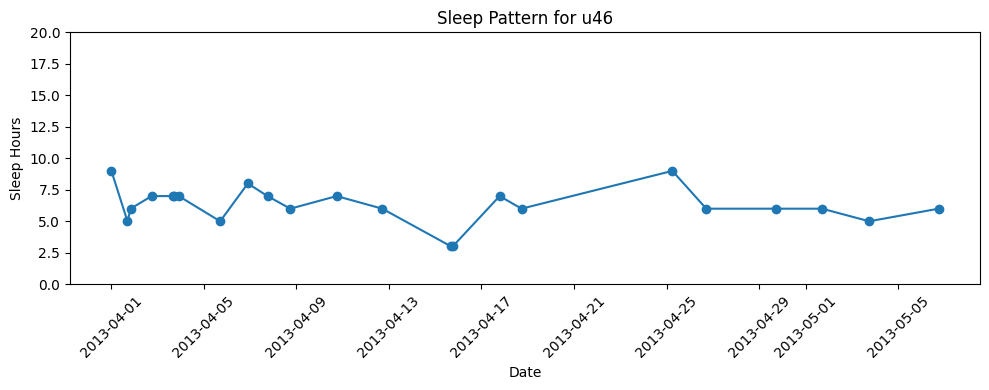

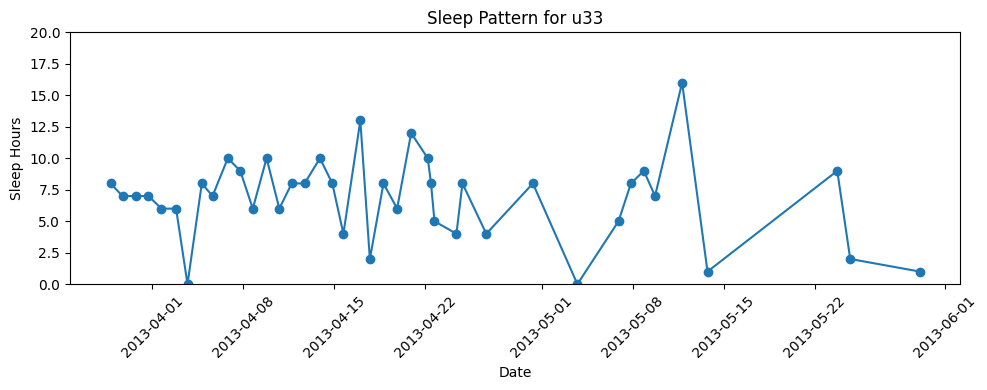

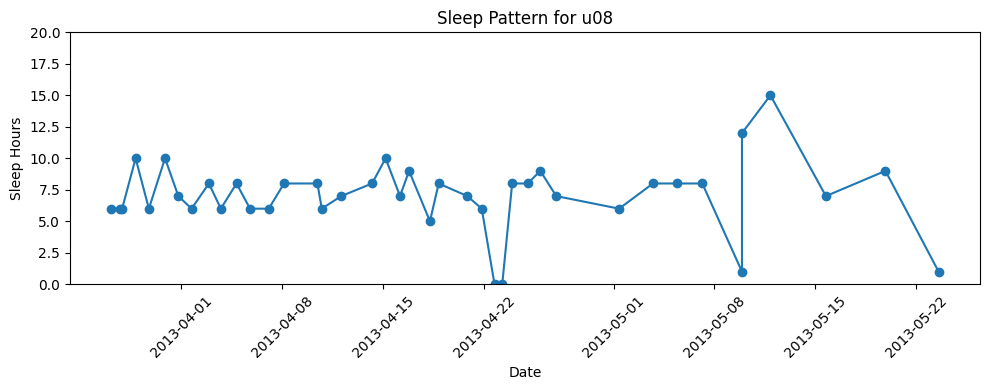

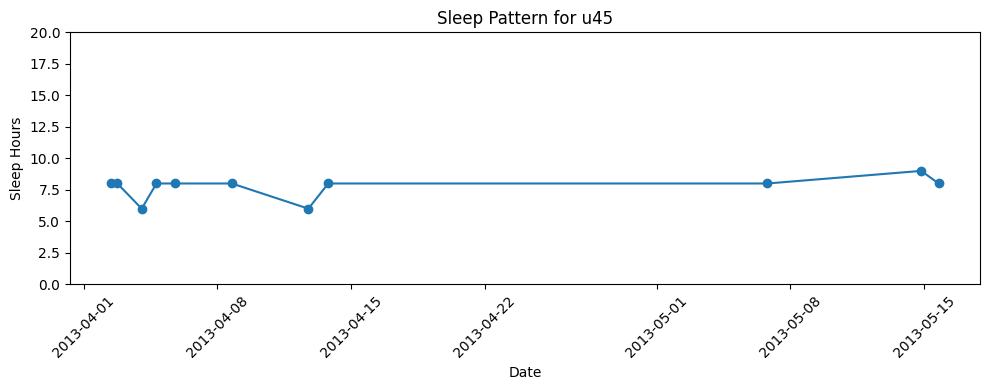

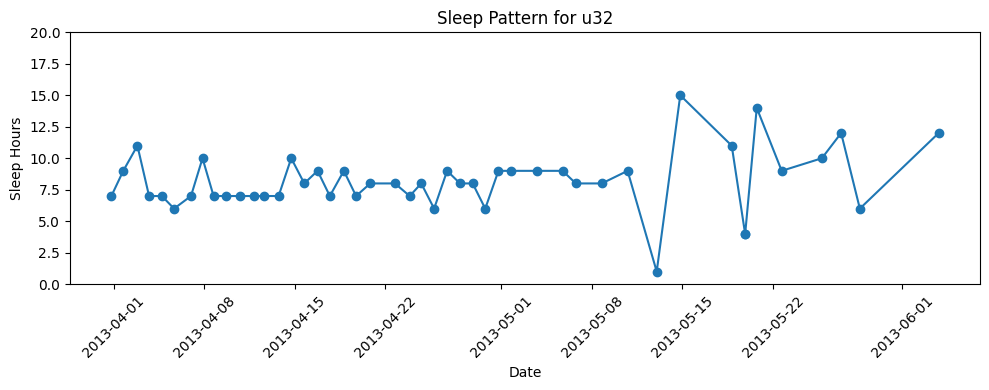

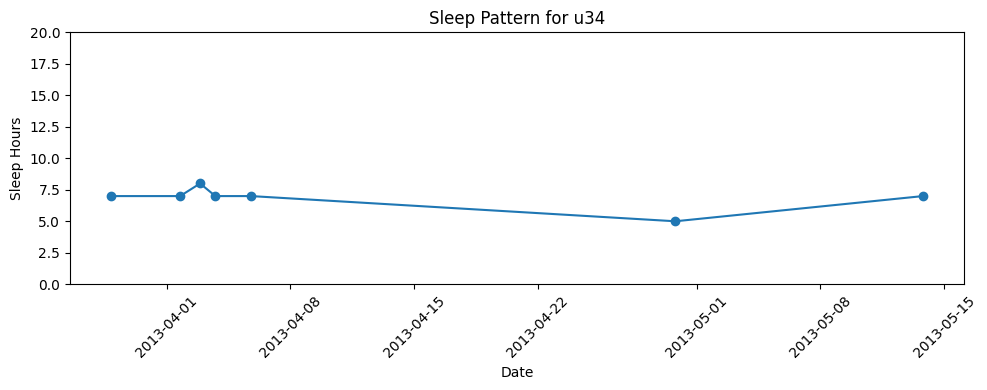

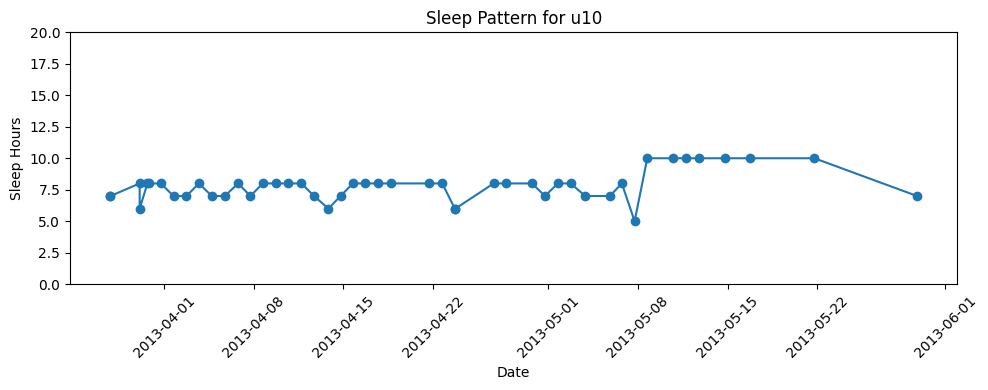

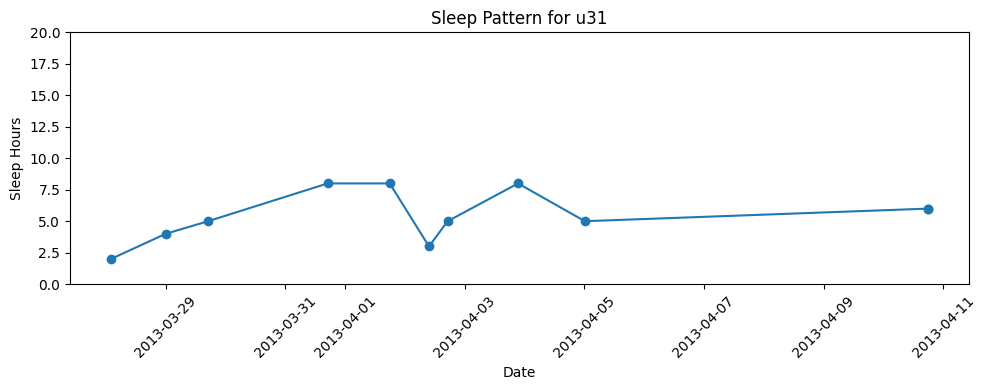

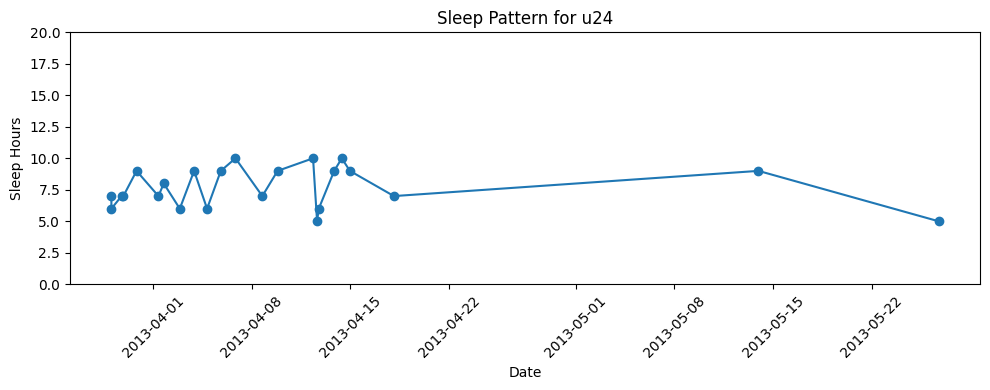

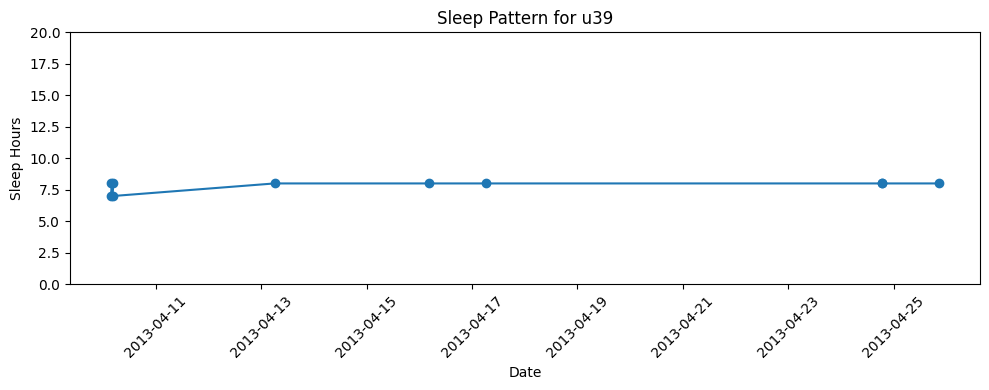

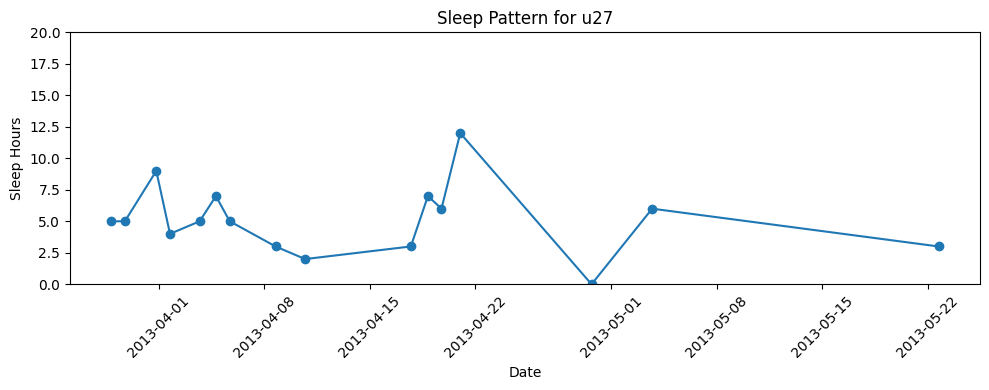

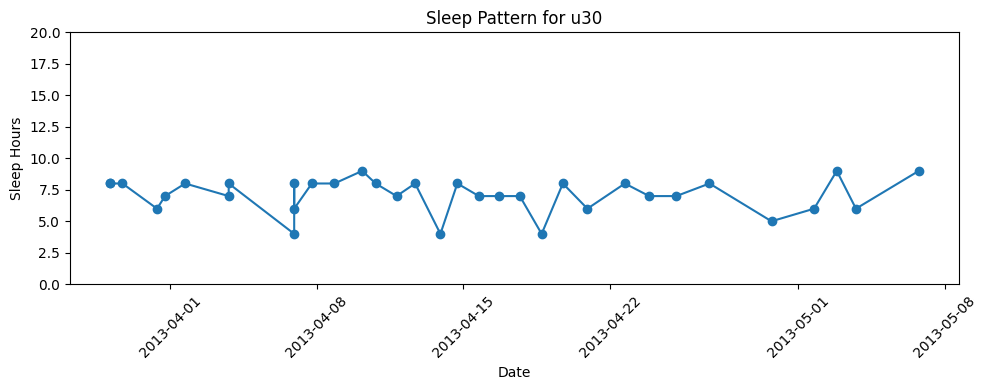

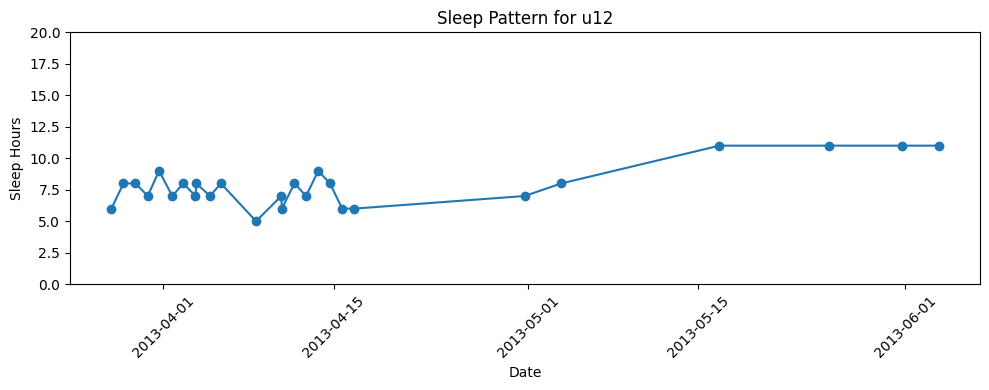

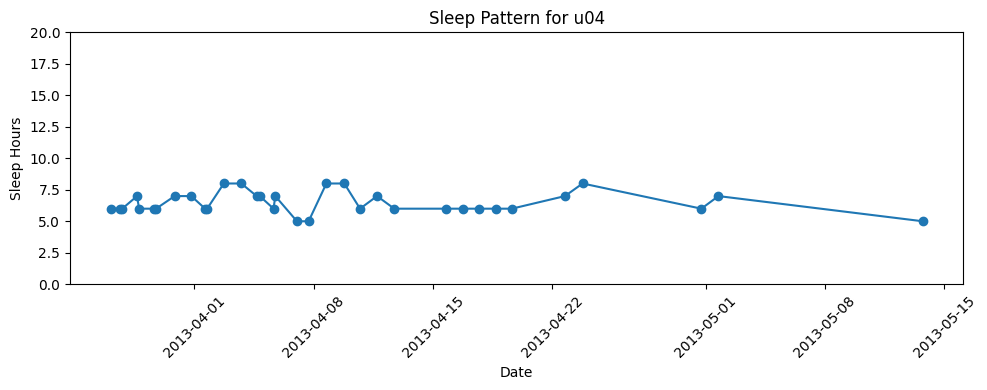

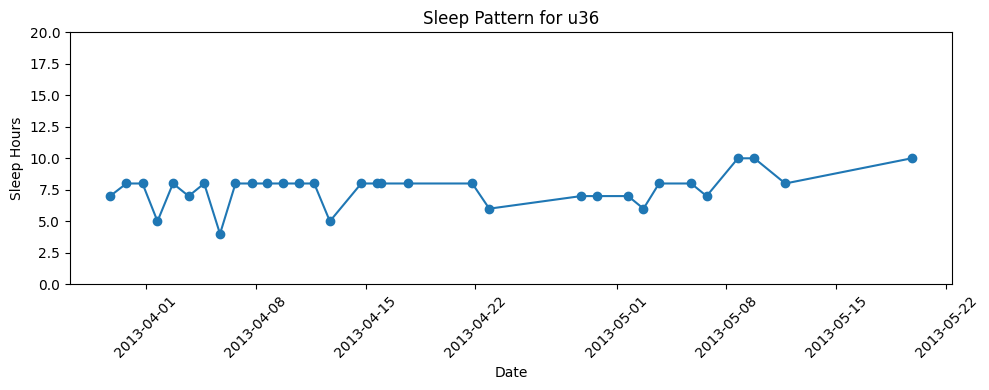

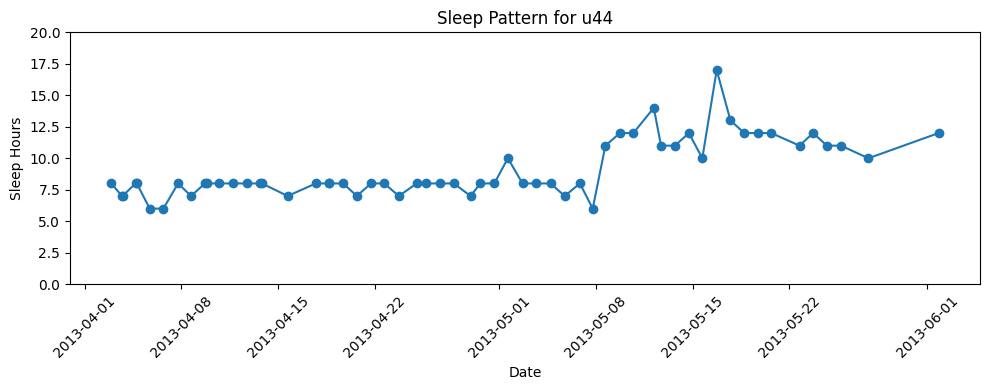

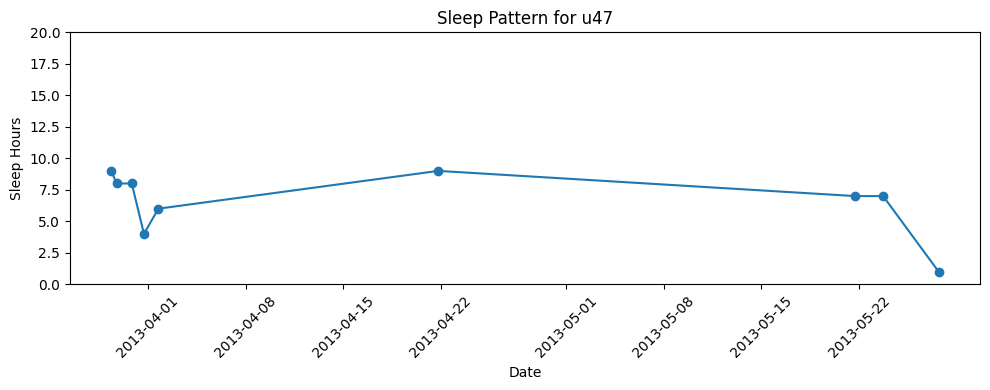

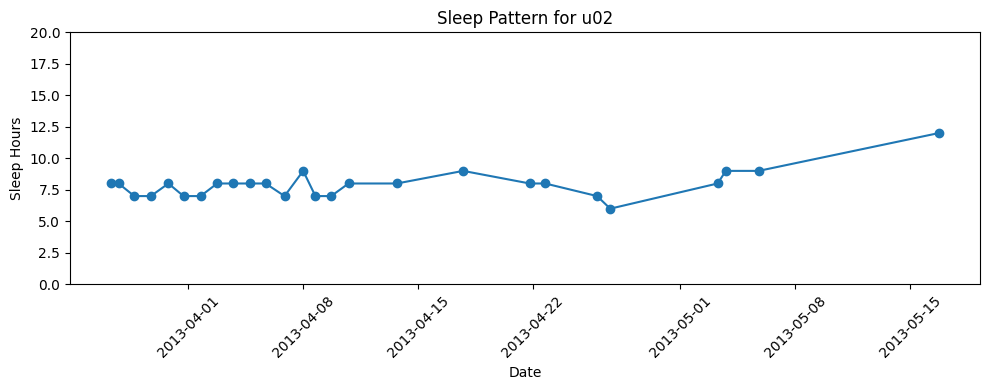

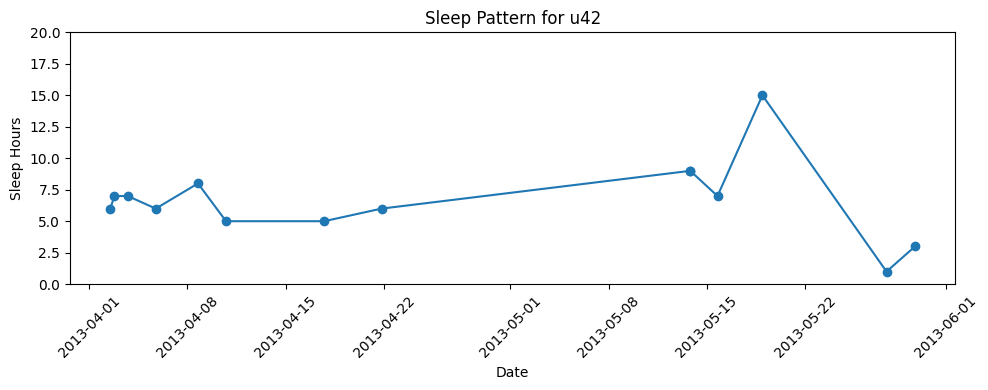

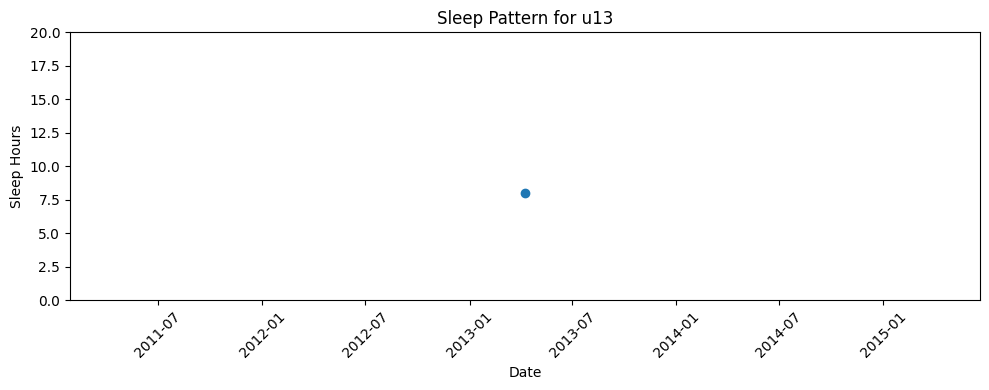

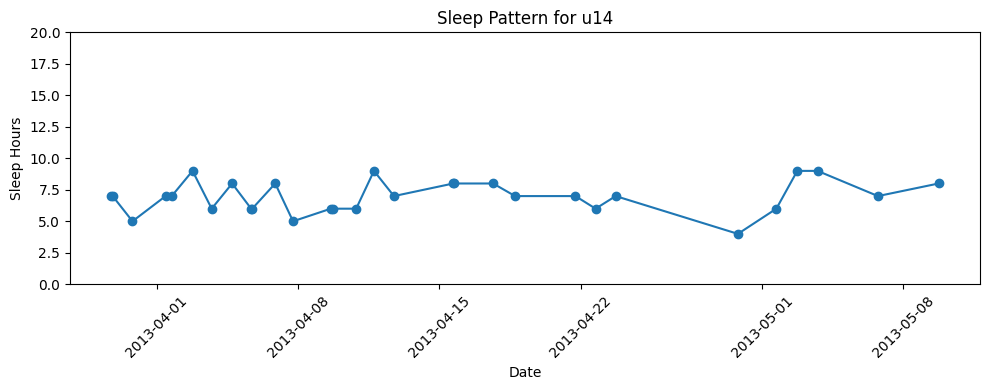

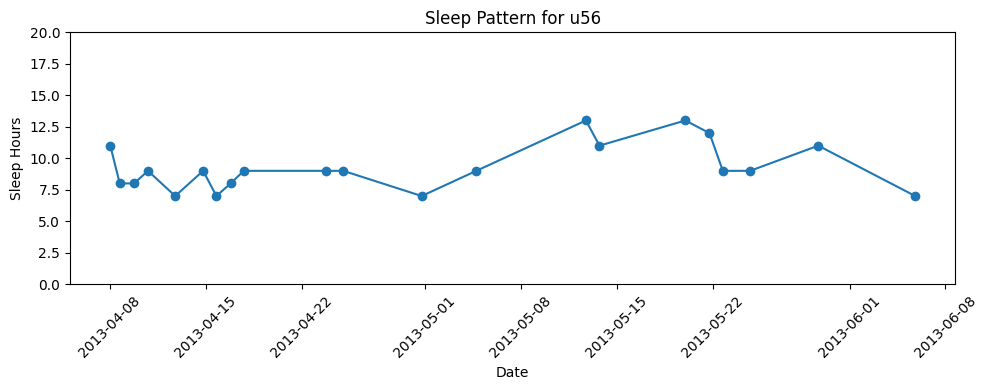

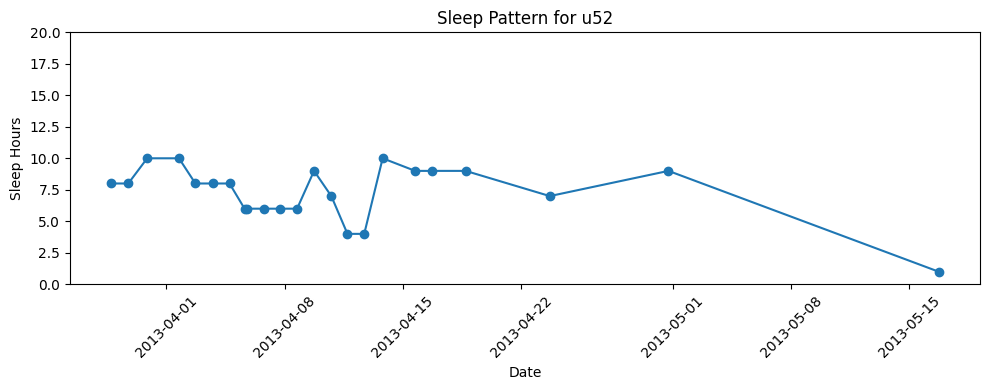

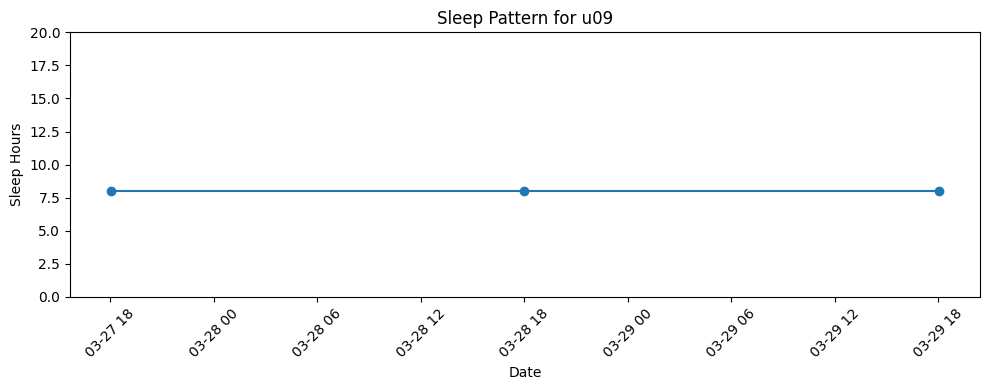

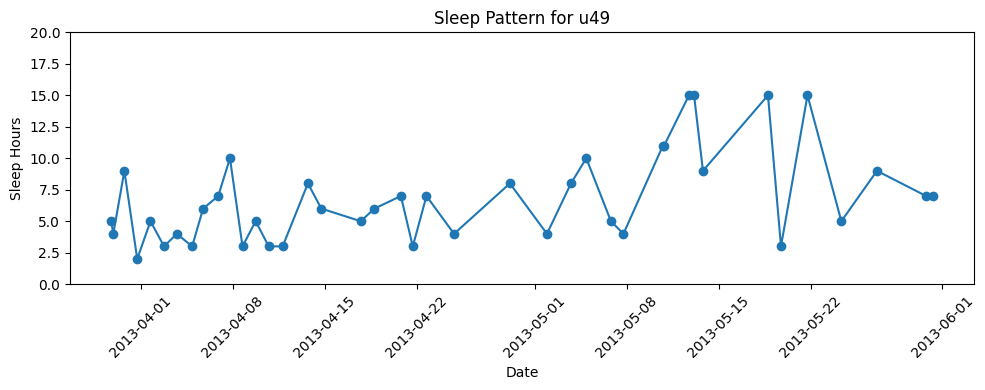

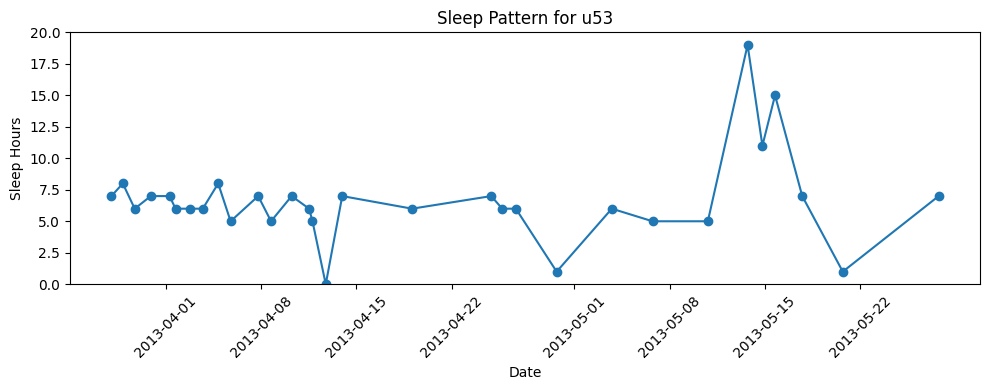

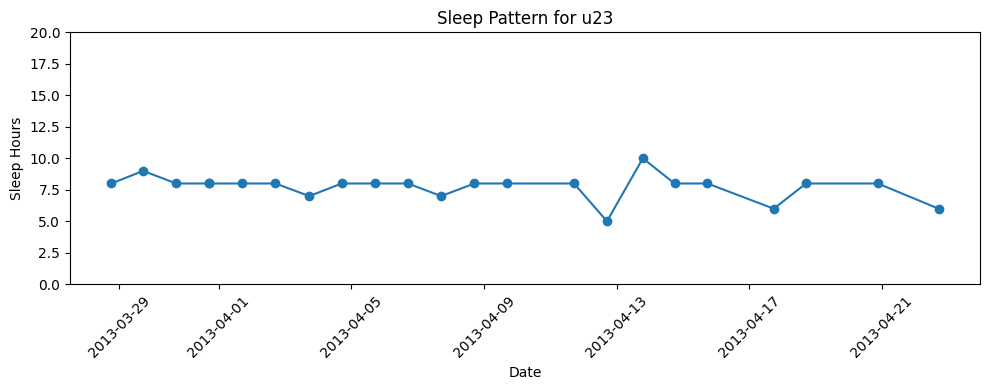

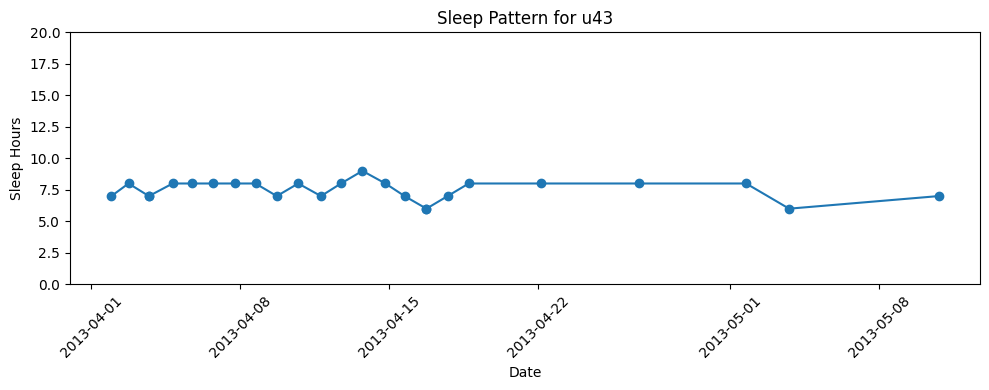

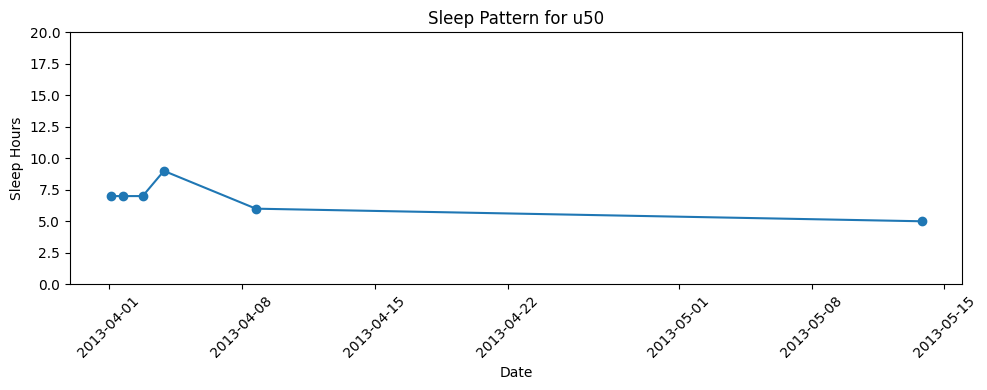

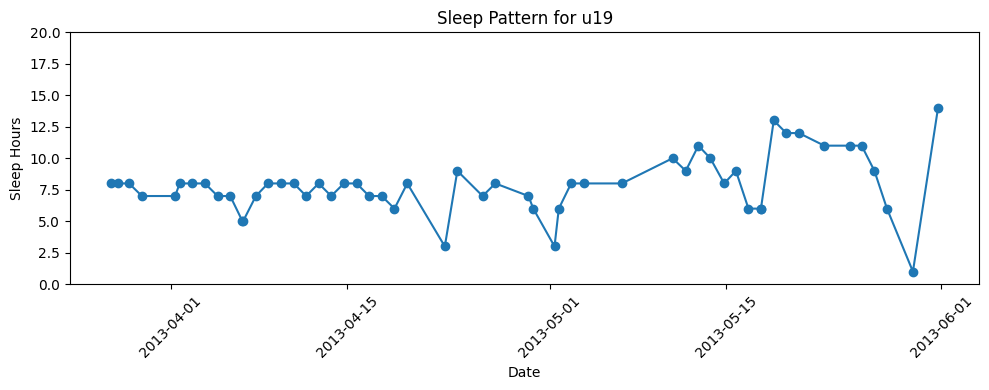

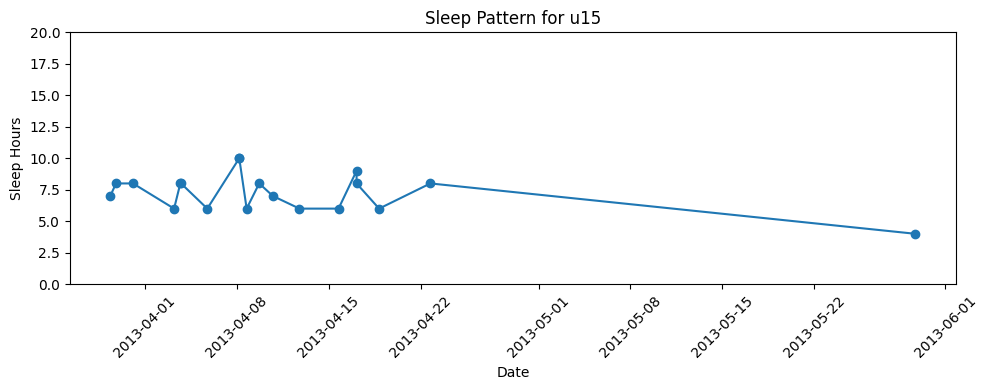

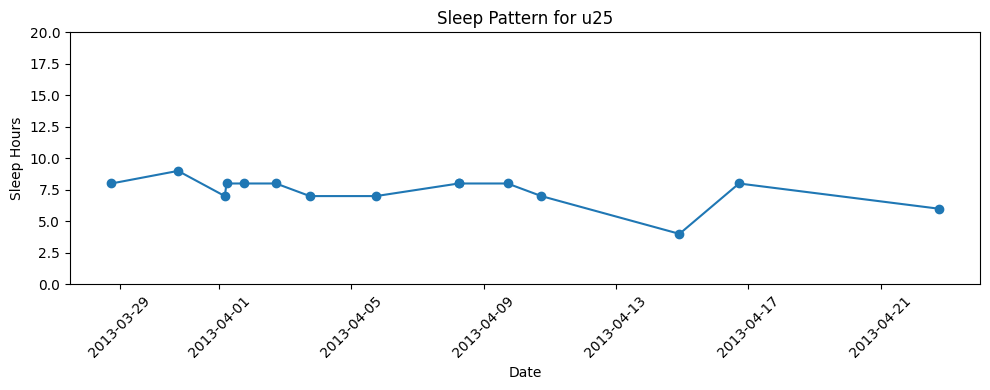

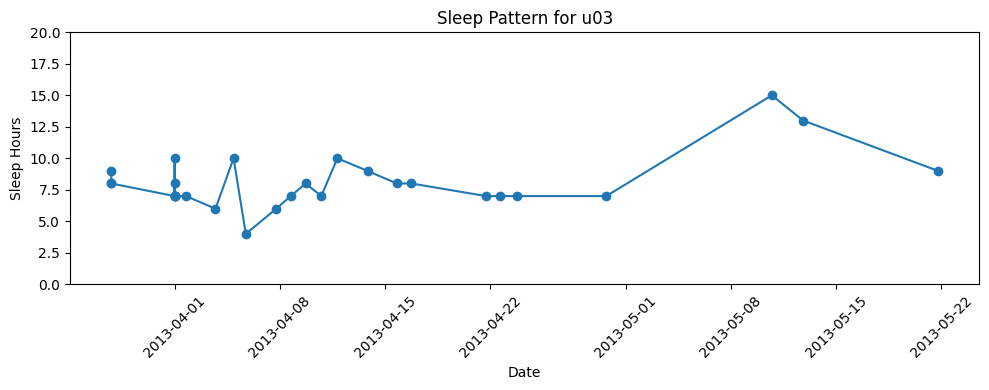

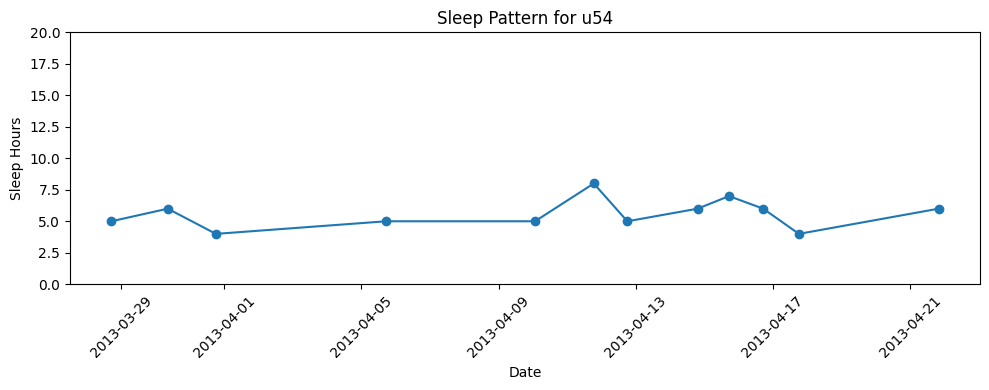

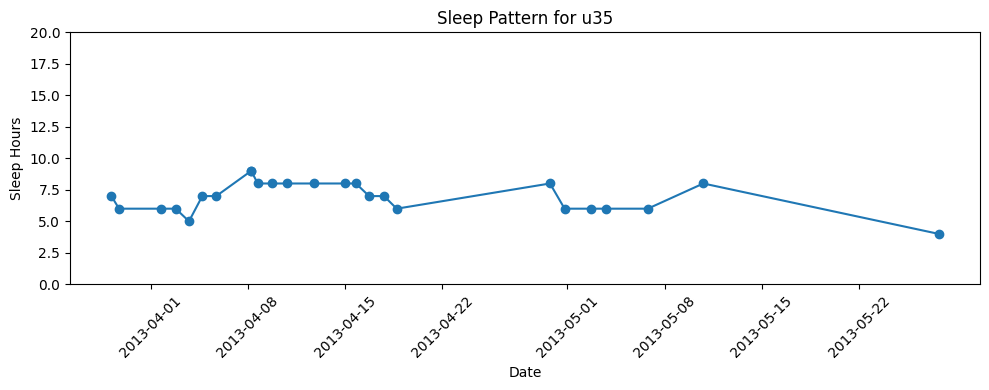

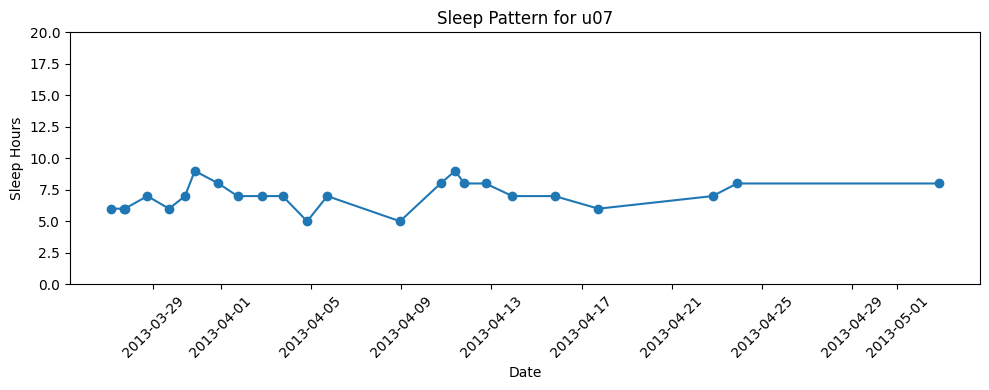

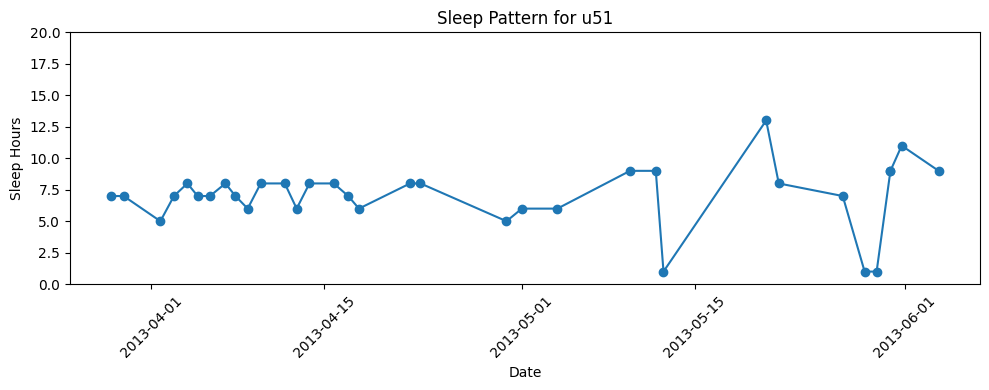

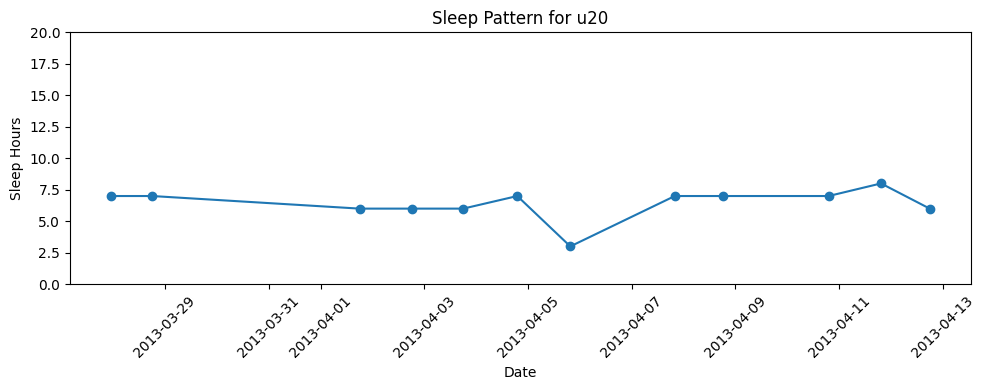

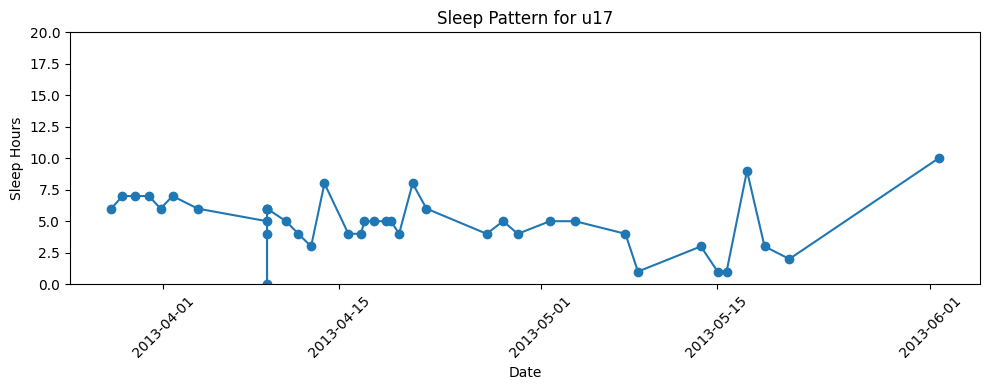

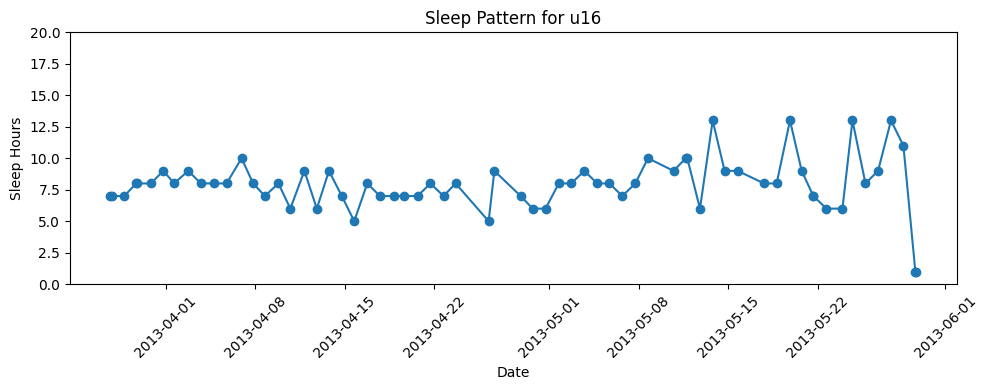

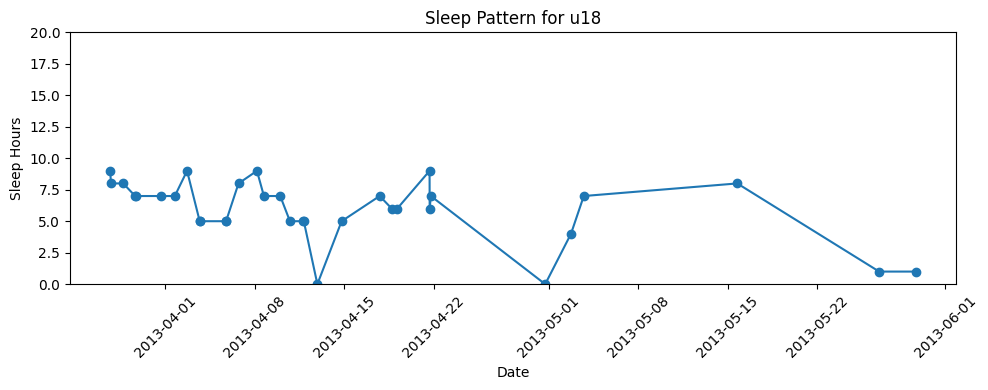

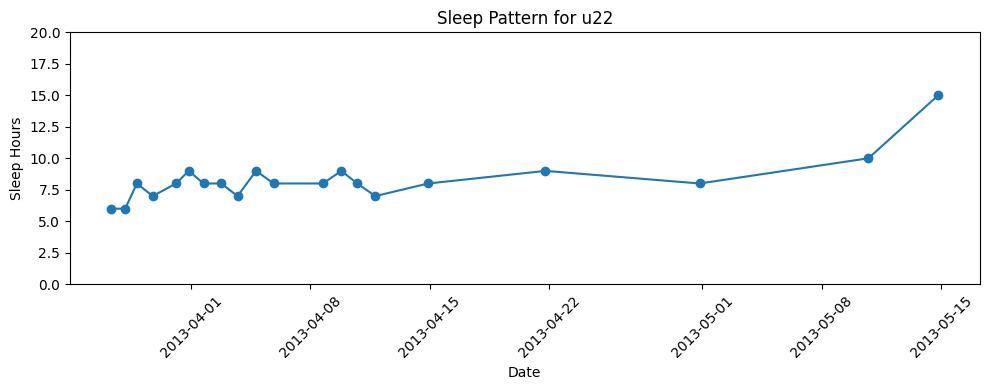

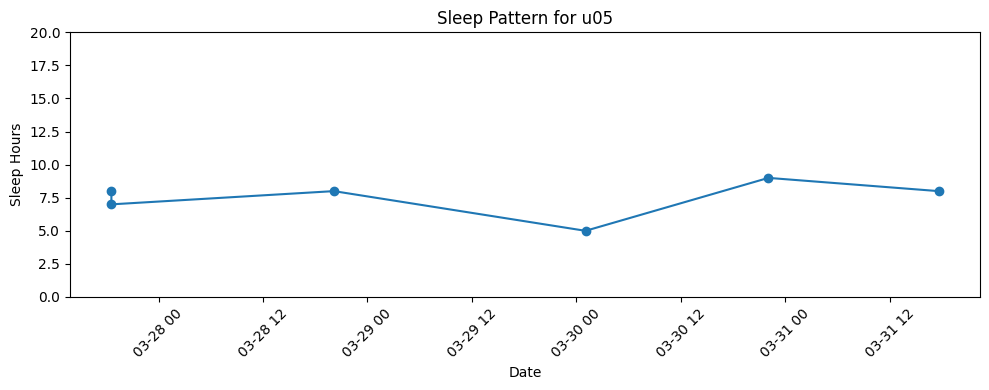

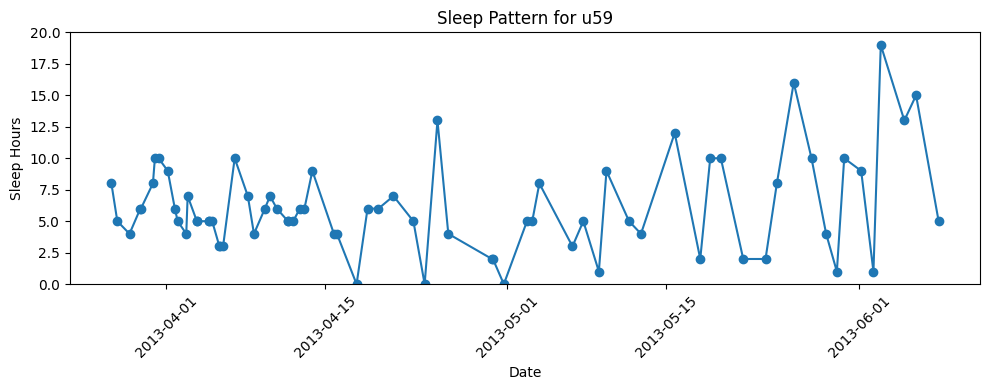

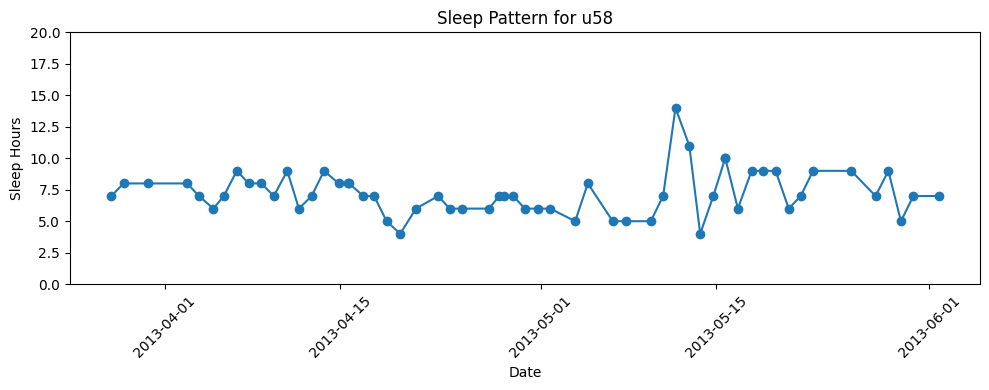

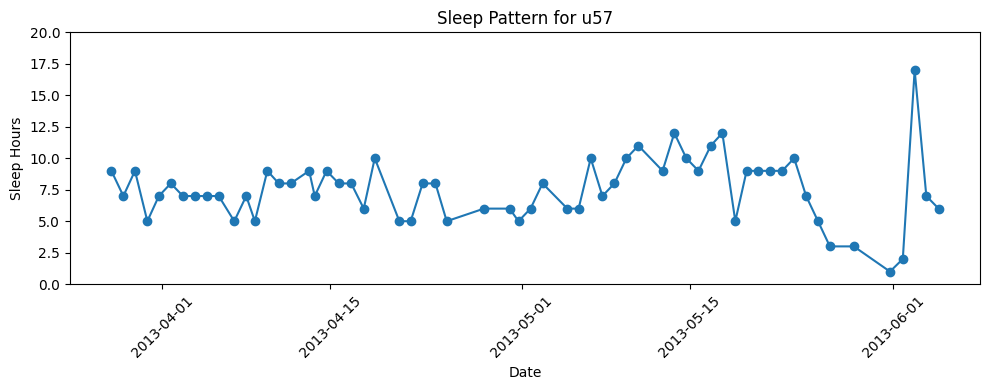

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime column is in datetime format
sleep_forward["datetime_utc"] = pd.to_datetime(sleep_forward["datetime_utc"])

# Get list of unique users
users = sleep_forward["user_id"].unique()

# Loop through each user and plot their sleep pattern
for user in users:
    user_df = sleep_forward[sleep_forward["user_id"] == user].sort_values(
        "datetime_utc"
    )

    plt.figure(figsize=(10, 4))
    plt.plot(user_df["datetime_utc"], user_df["sleep_hours"], marker="o", linestyle="-")

    plt.title(f"Sleep Pattern for {user}")
    plt.xlabel("Date")
    plt.ylabel("Sleep Hours")
    plt.xticks(rotation=45)
    plt.ylim(0, sleep_forward["sleep_hours"].max() + 1)
    plt.tight_layout()
    plt.show()